# Genetic Algorithm Learning and the Cobweb Model

The Cobweb model is a simple model of a market were:
- Firms are price takers
- Price is determined by total quantity of supply
- Goods produced are identical across firms



## Chromosomes


A population of chromosomes represents a collection of firms' decision rules.<br>
Each chromosome represents a decision of a firm.<br>

Defining chromosomes.
- Genotype X: a string of binary digits.
- Phenotype q: a real number, produce quantity for each time period.
- Fitness function F: fitness of a string i at time period t, which is determined by the value of firms' profit earned at the end of time t.
- Reproduction probability P(C): probability of contributing an offspring.

In [182]:
import numpy as np
import pandas as pd
import random
from copy import deepcopy
from alive_progress import alive_bar

In [183]:
class Chromosomes(object):
    def __init__(self):
        self.X = []
        self.q = 0
        self.F = 0
        self.prop = 0

In [184]:
def __get_quantity(x, q_bar, n_bits):
    # this function is used to decode the genotype and obtain the phenotype
    # x is an n_bits string over binary alphabet {0,1}
    # [0, q_bar] is the domain of firm's action
    q = 0
    for bit in x:
        q = (q << 1) | bit
    return q*q_bar/2**n_bits
    # denominator is a coefficient chosen to normalize the value 

In the example we use a 5-bit string: a string consisted with 5 binary digits, eg.[0,1,0,1,1] and a q_bar of 2.


In [185]:
__get_quantity([0,1,0,1,1],2,5)

0.6875

## GA:

Genetic algorithm, three genetic operators: <b>reproduction<b>, <b>crossover<b>, and <b>mutation<b>, while the other, in addition to these three, includes the <b>election<b> operator.
- Describe the evolution of a population of rules, representing different possible beliefs, in response to experience. 
- Frequency represents the credence.

## Single-population design：

A population of strings represents a population of agents with different opinions, each string standing for an individual agent.

In [289]:
class cobwebGA(object):

    def __init__(self,
                 n_chromosomes=30, # number of chromosomes and the firms
                 n_generations=30, 
                 n_bits=10,  # the length of the binary string
                 q_bar=7, # threshold
                 cr=0.002, # reproduction rate
                 mr=0.003, # mutation rate
                 A=100, # A and B are exogenous variables that determine the market price
                 B=0.02, # P_t = A - B*Q_t
                 x=1, # x and y are exogenous variables that determine the production cost
                 y=1): # pi = P*q-x*q-0.5*y*q^2

        self.__cr=cr
        self.__mr=mr

        self.__A=A
        self.__B=B
        self.__x=x
        self.__y=y
        self.__q_bar=q_bar

        self.__n_chromosomes=n_chromosomes
        self.__n_generations=n_generations
        self.__n_bits =n_bits

        self.__pop=[]
        self.__prob=[]
    

    def __sampling(self):
        # sampling strategy that allows for generating chromosomes with non-unique genotypes
        for _ in range(self.__n_chromosomes):
            # generate a string for every individual
            s = Chromosomes()
            s.X = list(np.random.randint(0, 2, n_bits))
            self.__pop.append(s)
 
    
    def __get_quantity(self, x):
        # genotype-phenotype decoder (as described above)
        q = 0
        for bit in x:
            q = (q << 1) | bit
        q = q*self.__q_bar/2**self.__n_bits
        return q   
   
            
    def __get_prices(self):
        # function to extract market prices
        Q = np.sum([s.q for s in self.__pop])
        P = self.__A-self.__B*Q
        return P
 
 
    def __profits(self, P, q): 
        # q is the number of production
        # fitness function (profit of single firm)
        pi = P*q-self.__x*q-0.5*self.__y*self.__n_chromosomes*(q**2)
        return pi
    
    
    def __get_q_star(self):
        # function to obtain rational expectations quantity equilibrium (later graphed with red dashed line)
        q_star = (self.__A-self.__x)/(self.__B+self.__y)
        return q_star

   
    def __get_p_star(self):
        # function to obtain rational expectations prices equilibrium (later graphed with red dashed line)
        q_star = self.__get_q_star()
        p_star = self.__A-self.__B*q_star
        return p_star
    


        
    # Reproduction makes the copies of individual chromosomes. 
    # The criterion used in copying is the value of the fitness function. 
    # Chromosomes with higher fitness value are assigned higher probability of contributing an offspring that undergoes further genetic operation.
    # A probability that a chromosome will get a copy is P=s.F/sum(s.F).
        
    def __get_probability(self, total_profits):
        # function to calculate the probability of a chromosome to contribute an offspring
        self.__prob=[]
        for s in self.__pop:
            s.prop = s.F/total_profits
            self.__prob.append(s.prop)
 
            
    def __reproduction(self):
        # select parents(string) for reproduction
        # once a string is selected, its exact copy is made
        # when n copies of strings are made (the number of strings in a population is kept constant the reproduction is completed and these copies constitute a mating pool which then undergoes the application of other genetic operators.
        populations = self.__pop
        probabilities = self.__prob
        mating_pool = random.choices(populations, weights=probabilities, k=self.__n_chromosomes)
        return mating_pool
        
        
    # Crossover exchanges the parts of pairs og randomly selected strings
    # 1st stage: two strings are selected from the mating pool at random
    # p1 = random.sample(mating_pool, 2)[0]
    # p2 = random.sample(mating_pool, 2)[1]
 
    # 2nd stage: a number pt is selected, again, randomly from 1 to n.bits-1, and two new strings are formed by swapping the set of binary values to the right of the position k 
    def __one_point_crossover(self, p1, p2):    

        c1, c2 = deepcopy(p1), deepcopy(p2) 
        # deepcopy recursively copies all objects found within the original, resulting in a completely
        # check for recombination
        if np.random.rand() < self.__cr:
            # select a crossover point
            pt = np.random.randint(1, len(p1.X)-2)
            # perform crossover
            c1.X = p1.X[:pt] + p2.X[pt:]
            c2.X = p2.X[:pt] + p1.X[pt:]

        return c1, c2


    # Mutation is the process of a random change of the value og a position with a string.
    # Each position has a small probability, pmut, of being altered by mutation, independently.
    def __mutation(self, s):
        # integer mutation and the selected bit is replaced with another bit value
        for i in range(len(s.X)):
            # check for a mutation
            if np.random.rand() < self.__mr:
                s.X[i] = 1-s.X[i] # exchange the value of 1 and 0

    
    # Election tests newly generated offsprings before they are permitted to become members of a new population.
    def __election(self, p1, p2, c1, c2, prev_price):
        # quantities are computed for each offspring
        c1.q = self.__get_quantity(c1.X)
        c2.q = self.__get_quantity(c2.X)
        # quantities are used to obtain profits with prices identical to previous generation
        c1.F = self.__profits(prev_price, c1.q)
        c2.F = self.__profits(prev_price, c2.q)
        # extract the best two individuals inside a family
        fam = [p1, p2, c1, c2]
        fam.sort(key=lambda x: x.F, reverse=True)
        c1 = fam[0]
        c2 = fam[1]
        return c1, c2

      


    def run(self, election=False):
        
        # populaiton initialization
        self.__sampling()
        
        # keep track of prices, quantity and generation for the market
        outputs = {
            'prices': [],
            'quantity': [],
            'average quantity': [],
            'gen': []
        }

        # keep track of prices, quantity and generation for all the chromosomes
        all_outputs = {
            'prices': [],
            'quantity': [],
            'profits':[],
            'gen': []
        }

        # enumerate generations
        with alive_bar(self.__n_generations, force_tty=True) as bar:
            for gen in range(self.__n_generations):

                gen_q = 0

                # extract individuals quantity
                for s in self.__pop:
                    s.q = self.__get_quantity(s.X)
                    all_outputs['quantity'].append(s.q)
                    gen_q = s.q+gen_q

                # extract price for generation
                price = self.__get_prices()
                #saving results of market price for interpretation
                outputs['prices'].append(price)

                # extract chromosome profits given the generation price
                for s in self.__pop:
                    s.F = self.__profits(price, s.q)
                    all_outputs['profits'].append(s.F)
                    all_outputs['prices'].append(price)
                    all_outputs['gen'].append(gen)
                
                # saving results of market outputs an n of generation for interpretation
                outputs['quantity'].append(gen_q)
                outputs['average quantity'].append(sum(all_outputs['quantity'])/len(all_outputs['quantity']))
                outputs['gen'].append(gen)
                
                # calculate the probability of a chromosome being chosen into the mating pool
                total_profits = sum(s.F for s in self.__pop)
                for s in self.__pop:
                    total_profits += s.F    
                s.prob = self.__get_probability(total_profits)
                
                # create the mating pool
                mating_pool = self.__reproduction()
                # create the next populations
                children = []
                
                for i in range(0, self.__n_chromosomes, 2):
                # get selected parents in pairs
                    p1 = random.sample(mating_pool, 2)[0]
                    p2 = random.sample(mating_pool, 2)[1]
                
                    # crossover
                    c1, c2 = self.__one_point_crossover(p1, p2)

                    # mutation
                    self.__mutation(c1)
                    self.__mutation(c2)

                    # election (if augmented GA is used)
                    if election:
                        c1, c2 = self.__election(p1, p2, c1, c2, price)

                    # store for next generation
                    children.append(c1)
                    children.append(c2)

                # replace population
                self.__pop = children[:]
                # counting for progress bar
                bar()
                outputs_df = pd.DataFrame.from_dict(outputs)
                all_outputs_df = pd.DataFrame.from_dict(all_outputs)

        return outputs_df, all_outputs_df

## Results of simulations

In [290]:
n_generations=100
n_chromosomes=30

n_bits=13
q_bar=5

c_r=0.9
m_r=0.005

A=100
B=0.02
x=3
y=1

Checking if result correspond to rational expectations model

In [291]:
def get_q_star(A, B, x, y, n):
    q_star=(A-x)/(n*(B+y))
    return q_star

def get_p_star(A, B, x, y):
    p_star=A-B*((A-x)/(B+y))
    return p_star

q_star=get_q_star(A=A, B=B, x=x, y=y, n=n_chromosomes)
p_star=get_p_star(A=A, B=B, x=x, y=y)

print('Equilibrium prices and quantity are',str(round(q_star,3)),'and',str(round(p_star,3)))

Equilibrium prices and quantity are 3.17 and 98.098


## Basic GA
- Election mechanism unenabled

In [298]:
ga = cobwebGA(n_chromosomes=n_chromosomes, n_generations=n_generations, n_bits=n_bits, q_bar=q_bar, cr=c_r, mr=m_r, A=A ,B=B , x=x , y=y)
outputs_df_b, all_outputs_df_b = ga.run(election=False)

|████████████████████████████████████████| 100/100 [100%] in 0.2s (651.84/s)    


In [299]:
print (outputs_df_b)

       prices    quantity  average quantity  gen
0   98.434229   78.288574          2.609619    0
1   97.979297  101.035156          2.988729    1
2   98.011023   99.448853          3.097473    2
3   97.955896  102.205200          3.174815    3
4   97.520166  123.991699          3.366463    4
..        ...         ...               ...  ...
95  98.018359   99.082031          3.512379   95
96  98.070178   96.491089          3.509328   96
97  98.048694   97.565308          3.506704   97
98  98.107056   94.647217          3.503150   98
99  97.981091  100.945435          3.501767   99

[100 rows x 4 columns]


In [300]:
print (all_outputs_df_b)

         prices  quantity     profits  gen
0     98.434229  4.232788  135.205441    0
1     98.434229  2.235718  138.387491    0
2     98.434229  3.828735  145.504189    0
3     98.434229  1.400757  104.248352    0
4     98.434229  2.479858  144.417908    0
...         ...       ...         ...  ...
2995  97.981091  2.629395  146.037028   99
2996  97.981091  2.630005  146.046849   99
2997  97.981091  4.074707  137.971560   99
2998  97.981091  3.879395  142.723597   99
2999  97.981091  2.620239  145.888378   99

[3000 rows x 4 columns]


## Argument GA
- Election mechanism enabled

In [301]:
outputs_df_a, all_outputs_df_a = ga.run(election=True)

|████████████████████████████████████████| 100/100 [100%] in 0.2s (446.52/s)    


In [302]:
print (outputs_df_a)

       prices    quantity  average quantity  gen
0   96.200000  190.000000          3.166667    0
1   97.777380  111.130981          3.345900    1
2   97.899438  105.028076          3.384659    2
3   98.211646   89.417725          3.303845    3
4   98.181042   90.947876          3.258470    4
..        ...         ...               ...  ...
95  98.125781   93.710938          3.123335   95
96  98.125366   93.731689          3.123346   96
97  98.125366   93.731689          3.123356   97
98  98.125366   93.731689          3.123366   98
99  98.125366   93.731689          3.123377   99

[100 rows x 4 columns]


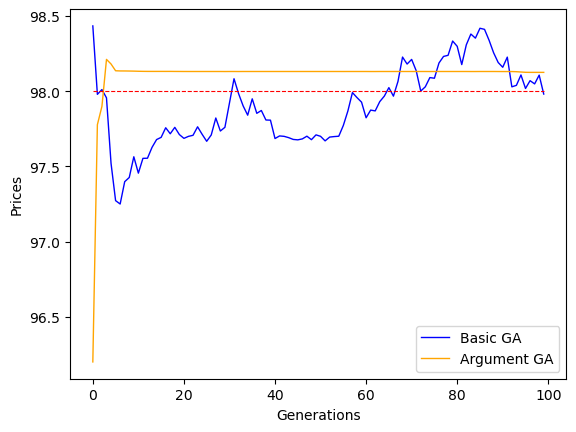

In [314]:
import matplotlib.pyplot as plt

x = [1*x for x in range(n_generations)]
array_basic = outputs_df_b['prices'].to_numpy()
array_argument = outputs_df_a['prices'].to_numpy()

fig = plt.figure()
plt.plot(x, array_basic, color='blue', linewidth=1, label='Basic GA')
plt.plot(x, array_argument, color='orange', linewidth=1, label='Argument GA')
plt.plot(x, np.full_like(x,p_star), linestyle='--', color='red', linewidth=0.8)
plt.ylabel('Prices', fontsize=10)
plt.xlabel('Generations', fontsize=10)
plt.legend(loc='best')
plt.show()